In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

dataframe = pd.read_csv(r"US_Accidents_March23.csv")


In [4]:
dataframe['Start_Time'] = pd.to_datetime(dataframe['Start_Time'], format='mixed', errors='coerce')
dataframe['End_Time'] = pd.to_datetime(dataframe['End_Time'], format='mixed', errors='coerce')
dataframe['Weather_Timestamp'] = pd.to_datetime(dataframe['Weather_Timestamp'], format='mixed', errors='coerce')
dataframe[['Start_Time', 'End_Time', 'Weather_Timestamp']].dtypes

dataframe['Hour'] = dataframe['Start_Time'].dt.hour
dataframe['Hour'].value_counts().sort_index()
dataframe['Duration_min'] = (dataframe['End_Time'] - dataframe['Start_Time']).dt.total_seconds() / 60
infra_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                 'Traffic_Signal', 'Turning_Loop']
dataframe['Infra_Count'] = dataframe[infra_columns].astype(int).sum(axis=1)
# Seleccionar variables numéricas relevantes para clustering
features = [
    'Severity',
    'Distance(mi)',
    'Temperature(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Duration_min',
    'Hour',
    'Infra_Count'
]
df_cluster = dataframe[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [5]:
dataframe[features].describe()


,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Duration_min,Hour,Infra_Count
count,7.728394e+06,7.728394e+06,7.564541e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,7.728394e+06,7.728394e+06,7.728394e+06
mean,2.212384e+00,5.618423e-01,6.166329e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,4.444210e+02,1.232857e+01,4.187092e-01
std,4.875313e-01,1.776811e+00,1.901365e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.351229e+04,5.464796e+00,7.341311e-01
min,1.000000e+00,0.000000e+00,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.216667e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,4.900000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,3.150000e+01,8.000000e+00,0.000000e+00
50%,2.000000e+00,3.000000e-02,6.400000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,7.483333e+01,1.300000e+01,0.000000e+00
75%,2.000000e+00,4.640000e-01,7.600000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,1.251500e+02,1.700000e+01,1.000000e+00
max,4.000000e+00,4.417500e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,2.812939e+06,2.300000e+01,7.000000e+00


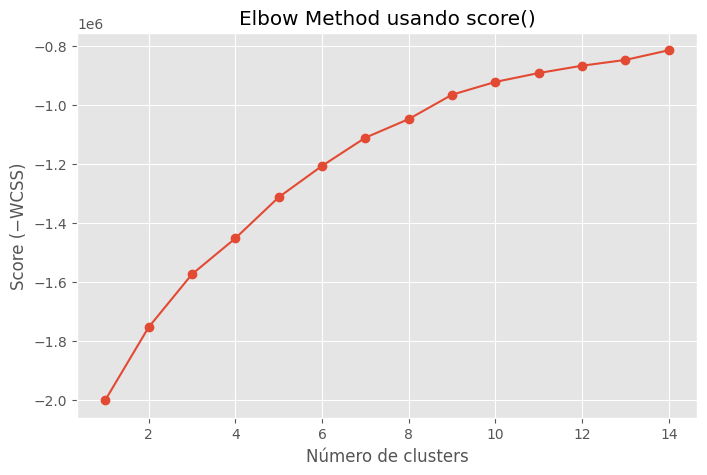

In [8]:
df_sample = df_cluster.sample(n=200_000, random_state=42)
X_sample = scaler.fit_transform(df_sample)

Nc = range(1, 15)
score = []

for k in Nc:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_sample)
    score.append(kmeans.score(X_sample))


plt.figure(figsize=(8,5))
plt.plot(Nc, score, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Score (−WCSS)')
plt.title('Elbow Method usando score()')
plt.grid(True)
plt.show()


In [9]:
k_optimo = 4

kmeans = KMeans(
    n_clusters=k_optimo,
    init='k-means++',
    n_init=10,
    random_state=42
)

df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

In [10]:
df_cluster['Cluster'].value_counts().sort_index()


Cluster
0    1226999
1    2472396
2       4243
3    3392049
Name: count, dtype: int64

In [11]:
cluster_profile = df_cluster.groupby('Cluster').mean()
cluster_profile


,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Duration_min,Hour,Infra_Count
Cluster,,,,,,,,,,
0,3.147634,0.555292,63.462719,63.151067,29.627425,9.416461,8.364855,126.804961,13.020921,0.246760
1,2.025645,0.650534,50.002166,82.309491,29.424606,7.777561,6.042645,137.388109,8.471162,0.387269
2,2.204101,1.490762,64.399859,72.269149,29.908331,9.244179,7.629672,541183.211415,12.815461,0.214707
3,1.989691,0.516729,69.937231,51.816659,29.534716,9.965133,8.647048,135.807848,15.096782,0.503468


In [12]:
df_cluster.groupby('Cluster')['Severity'].value_counts(normalize=True)


Cluster  Severity
0        3           0.852351
         4           0.147642
         2           0.000007
1        2           0.952935
         3           0.036350
         1           0.010712
         4           0.000004
2        2           0.896771
         4           0.101343
         3           0.001650
         1           0.000236
3        2           0.987334
         1           0.011487
         3           0.001178
Name: proportion, dtype: float64

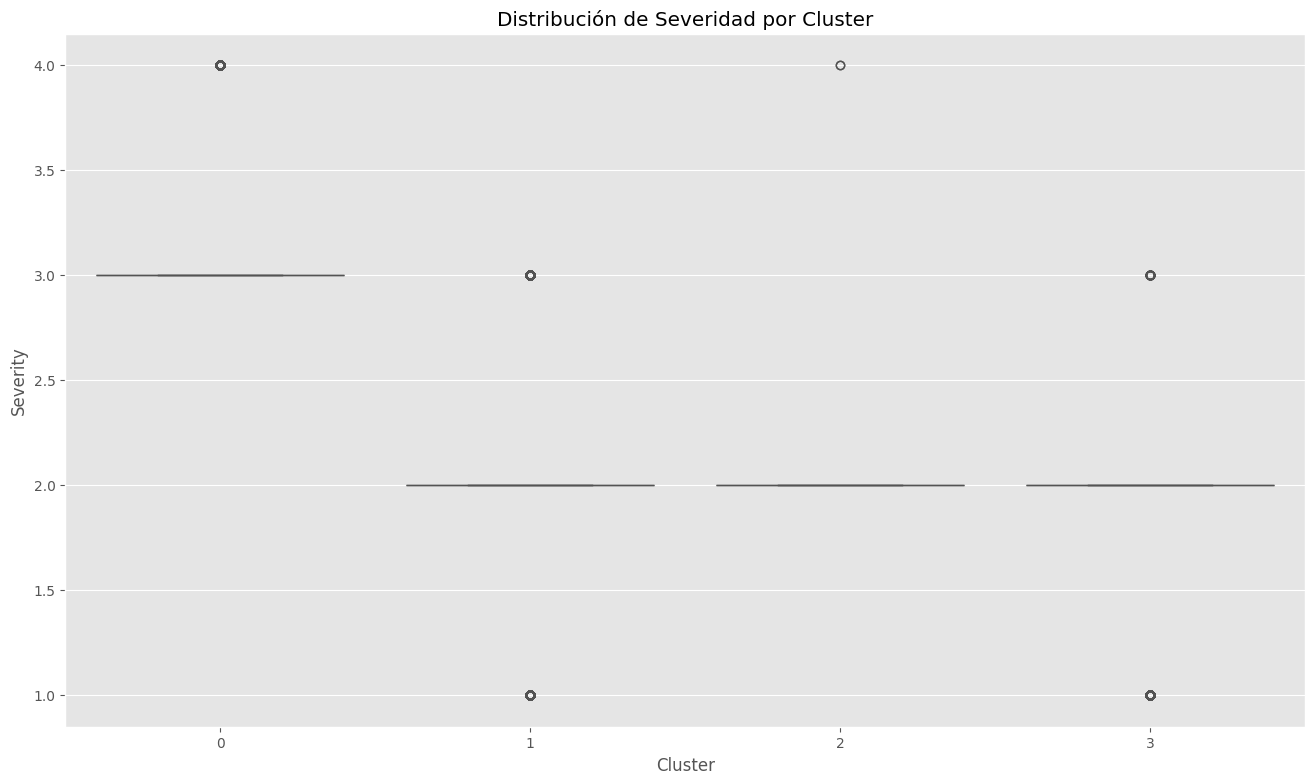

In [13]:
import seaborn as sns

sns.boxplot(x='Cluster', y='Severity', data=df_cluster.sample(50_000))
plt.title('Distribución de Severidad por Cluster')
plt.show()